In [1]:
import os
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torchaudio.transforms as T
import torchvision
import torch.optim as optim
import scipy as sp
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import datetime

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [2]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename_tot = 'EPIC_100_train_clean.pkl'
filename_train = 'EPIC_100_train_clean_split.pkl'
filename_valid = 'EPIC_100_validation_split.pkl'
filename_test = 'EPIC_100_test_split.pkl'

img_dir = os.path.join('..','reports','img','dataset_analysis')

In [3]:
def load_data(filename):
    '''
    Load the WAV file and its label.
    Args :
        • filename: str. The path of a WAV file.
    Returns A tuple of two Pandas DataFrame objects:
        • signals: A DataFrame with the following columns:
            • seconds: The time in seconds.
            • AcclX: The acceleration along the x-axis.
            • AcclY: The acceleration along the y-axis.
            • AcclZ: The acceleration along the z-axis.
            • GyroX: The angular velocity along the x-axis.
            • GyroY: The angular velocity along the y-axis.
            • GyroZ: The angular velocity along the z-axis.
        • sampling_rate: The sampling rate of the WAV file.
    '''
    df_accl = pd.read_csv(filename + '-accl.csv').dropna().reset_index(drop=True)
    df_gyro = pd.read_csv(filename + '-gyro.csv').dropna().reset_index(drop=True)

    return df_accl, df_gyro

In [4]:
df_train = pd.read_pickle(os.path.join(annotations_dir, filename_train))
df_train = df_train.dropna().reset_index(drop=True)
df_train

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01,P01_102,00:00:07.600,7.49,9.05,374,452,move spatula and colander,move,11,spatula,20,"[spatula, colander]","[20, 39]"
1,P01,P01_102,00:00:29.851,29.66,30.84,1483,1542,take knife,take,0,knife,4,[knife],[4]
2,P01,P01_102,00:03:44.600,224.45,225.00,11222,11250,wipe surface,wipe,2,surface,42,[surface],[42]
3,P01,P01_102,00:03:45.600,225.61,226.01,11280,11300,move glass,move,11,glass,10,[glass],[10]
4,P01,P01_102,00:03:46.851,226.06,226.56,11303,11328,wipe surface,wipe,2,surface,42,[surface],[42]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27856,P35,P35_109,00:04:55.363,292.09,297.36,14604,14868,put down scissors,put-down,1,scissors,79,[scissors],[79]
27857,P35,P35_109,00:05:00.120,296.85,300.98,14842,15049,pick up mug,pick-up,0,mug,13,[mug],[13]
27858,P35,P35_109,00:05:01.617,301.08,302.20,15054,15110,put down mug,put-down,1,mug,13,[mug],[13]
27859,P35,P35_109,00:05:02.363,302.82,303.71,15141,15185,pick up mug,pick-up,0,mug,13,[mug],[13]


In [5]:
df_valid = pd.read_pickle(os.path.join(annotations_dir, filename_valid))
df_valid = df_valid.dropna()
df_valid = df_valid.reset_index(drop=True)
df_valid

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P09,P09_103,00:00:06.704,5.13,9.38,256,469,turn on stove,turn-on,6,stove,24,[stove],[24]
1,P09,P09_103,00:00:09.980,9.47,10.38,473,519,take oil bottle,take,0,bottle:oil,15,[bottle:oil],[15]
2,P09,P09_103,00:01:10.840,70.09,127.91,3504,6395,slice chicken,slice,7,chicken,57,[chicken],[57]
3,P09,P09_103,00:02:21.660,139.00,146.32,6950,7316,add chicken breast to pan,add,46,breast:chicken,57,[breast:chicken],[57]
4,P09,P09_103,00:02:31.140,149.58,155.15,7478,7757,clean hands,clean,2,hand,11,[hand],[11]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3345,P28,P28_113,00:04:37.408,275.17,280.95,13758,14047,take rubbish bag,take,0,bag:rubbish,19,[bag:rubbish],[19]
3346,P28,P28_113,00:04:42.151,281.64,282.53,14082,14126,close drawer,close,4,drawer,8,[drawer],[8]
3347,P28,P28_113,00:04:48.408,288.32,294.43,14416,14721,place rubbish bag in bin,place,1,bag:rubbish,19,"[bag:rubbish, bin]","[19, 36]"
3348,P28,P28_113,00:04:54.906,294.92,295.60,14746,14780,close bin lid,close,4,lid:bin,6,[lid:bin],[6]


In [6]:
df_test = pd.read_pickle(os.path.join(annotations_dir, filename_test))
df_test = df_test.dropna()
df_test = df_test.reset_index(drop=True)
df_test

,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P06,P06_101,00:00:02.903,2.20,3.95,110,197,open fridge,open,3,fridge,12,[fridge],[12]
1,P06,P06_101,00:00:04.654,3.97,5.70,198,285,pull drawer,pull,31,drawer,8,[drawer],[8]
2,P06,P06_101,00:00:25.655,25.06,26.02,1253,1301,pick up sweet potato,pick-up,0,potato:sweet,30,[potato:sweet],[30]
3,P06,P06_101,00:06:01.405,361.78,366.59,18089,18329,chop garlic,chop,7,garlic,51,[garlic],[51]
4,P06,P06_101,00:06:07.904,367.62,372.31,18381,18615,chop garlic,chop,7,garlic,51,[garlic],[51]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,P37,P37_103,00:06:16.404,376.42,377.29,18821,18864,wash hands,wash,2,hand,11,[hand],[11]
6064,P37,P37_103,00:06:16.903,377.17,377.67,18858,18883,turn off tap,turn-off,8,tap,0,[tap],[0]
6065,P37,P37_103,00:06:22.154,377.86,383.77,18893,19188,take pan,take,0,pan,5,[pan],[5]
6066,P37,P37_103,00:00:41.151,40.57,44.19,2028,2209,debone chicken thighs,debone,30,thigh:chicken,57,[thigh:chicken],[57]


In [ ]:
len(df_valid['verb_class'].sort_values().unique()), len(df_test['verb_class'].sort_values().unique())

In [ ]:
df = pd.concat([df_valid, df_test], ignore_index=True)

In [ ]:
len(df['verb_class'].sort_values().unique())

In [ ]:
len(df_train['verb_class'].sort_values().unique())

In [ ]:
df = pd.read_pickle(os.path.join(annotations_dir, filename_tot))
df = df.dropna().reset_index(drop=True)
df

In [ ]:
df['verb_class'].sort_values().unique()

In [ ]:
cls = {}
[cls.update({c: i}) for i, c in enumerate(df['verb_class'].sort_values().unique())]
pkl.dump(cls, open(os.path.join(annotations_dir, 'cls.pkl'), 'wb'))

In [ ]:
len(cls)

In [ ]:
df_valid = pd.read_pickle(os.path.join(annotations_dir, filename_valid))
df_valid = df_valid.dropna()
df_valid = df_valid.reset_index(drop=True)
df_valid

# IMU data size

In [ ]:
sz = 0
for video_id in df['video_id'].unique():
    participant_id = video_id.split('_')[0]
    clip_path = os.path.join(root_dir, participant_id, 'meta_data', video_id)
    sz += os.path.getsize(clip_path + '-accl.csv') + os.path.getsize(clip_path + '-gyro.csv')

last = 'bytes'
for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
    if sz < 1024.0:
        last = x
        break
    sz /= 1024.0
print("Data Size: ", sz, last)

In [ ]:
accl_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'AcclX', 'AcclY', 'AcclZ'])
gyro_data = pd.DataFrame(columns=['video_id', 'Milliseconds', 'GyroX', 'GyroY', 'GyroZ'])

In [ ]:
df[['verb', 'verb_class']].where(df['verb_class'] == 1).dropna()

# 1. Actions Duration

<Axes: title={'center': 'Duration of the training set videos'}, ylabel='Frequency'>

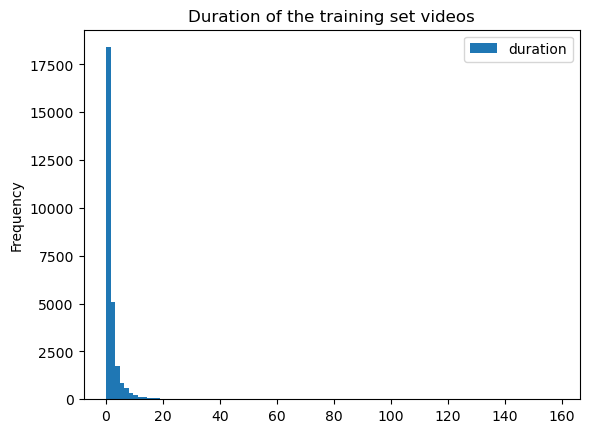

In [22]:
df_duration = pd.DataFrame({'duration': df_train['stop_timestamp'] - df_train['start_timestamp']})
df_duration.sort_values(by='duration', ascending=False).plot(y='duration', kind='hist', bins=100, title='Duration of the training set videos')

## Discrepanza col dataset
Dovrebbero esserci:
* verbs: 97
* nouns: 300

In [ ]:
len(df['verb_class'].unique()), len(df['verb'].unique())

In [ ]:
len(df['noun_class'].unique()), len(df['noun'].unique())

In [ ]:
tmp_df = df
tmp_df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='%H:%M:%S.%f')
tmp_df['stop_timestamp'] = pd.to_datetime(df['stop_timestamp'], format='%H:%M:%S.%f')

diff_df = pd.DataFrame({
    'diff': df['stop_timestamp'] - df['start_timestamp'],
    'verb': df['verb'],
    'verb_class': df['verb_class'],
    'noun': df['noun'],
    'noun_class': df['noun_class'],
})

In [ ]:
diff_df

In [ ]:
diff_df['diff'].describe()

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Calculate mean and standard deviation
mean = diff_df['diff'].mean().total_seconds()
std = diff_df['diff'].std().total_seconds()

# Generate x values for the Gaussian curve
x = np.linspace(mean - 3*std, mean + 3*std, 100)

# Calculate y values using the Gaussian distribution
y = norm.pdf(x, mean, std)

# Plot the Gaussian curve
plt.plot(x, y)
plt.xlabel('Duration (seconds)')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution of Durations')
plt.xlim(left=0)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_pdf.svg'))


In [ ]:
diff_df['diff'].dt.total_seconds().describe()

In [ ]:
import matplotlib.pyplot as plt

stats = np.ceil(diff_df['diff'].dt.total_seconds().to_numpy()).astype(int)
limit = 20

labels, counts = np.unique(stats, return_counts=True)
x = np.arange(labels.max())
# Plot the distribution of 'diff' column
plt.bar(labels.astype(str), counts, data=counts, align='center')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Durations')
plt.margins(x=0.01, y=0.1)
plt.xlim(0, 20)
plt.show()
plt.savefig(os.path.join(img_dir, 'duration_distribution_bar.svg'))

# Label frequencies

In [ ]:
df['verb_class'].value_counts().head(20).plot(kind='bar')

# IMU splits

In [1]:
%cd ..

/home/gatanasio/SSPT_IMU


/home/gatanasio/miniconda3/envs/audio-mae/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%cd src

/home/gatanasio/SSPT_IMU/src


In [3]:
from data.epic_dataset import EpicDataset
import os

In [4]:
root_dir = os.path.join('/data', 'EPIC-KITCHENS')
annotations_dir = os.path.join('..', 'data', 'annotations')
train = True
filename_train = 'EPIC_100_train_clean.pkl'

In [8]:
dataset = EpicDataset(
    src_dir=root_dir,
    annotations=annotations_dir,
    filename=filename_train,
)

annotations = dataset.annotations

37279


In [9]:
del dataset
len(annotations)

37279

In [30]:
actions_count_per_pid = annotations['verb_class'].value_counts()
actions_count_per_pid

verb_class
0     8952
1     7238
2     3524
3     2367
4     1814
      ... 
58       3
94       3
85       2
88       1
95       1
Name: count, Length: 89, dtype: int64

In [36]:
threshold = 100
actions_count_per_pid = actions_count_per_pid[actions_count_per_pid > threshold]
f'Filtered labels with more than {threshold} instances: {len(actions_count_per_pid)}'

'Filtered labels with more than 100 instances: 35'

In [37]:
all = annotations.loc[annotations['verb_class'].isin(actions_count_per_pid.index)]
f'Filtered dataset length: {len(all)}'

'Filtered dataset length: 35598'

<Axes: xlabel='verb_class', ylabel='# actions'>

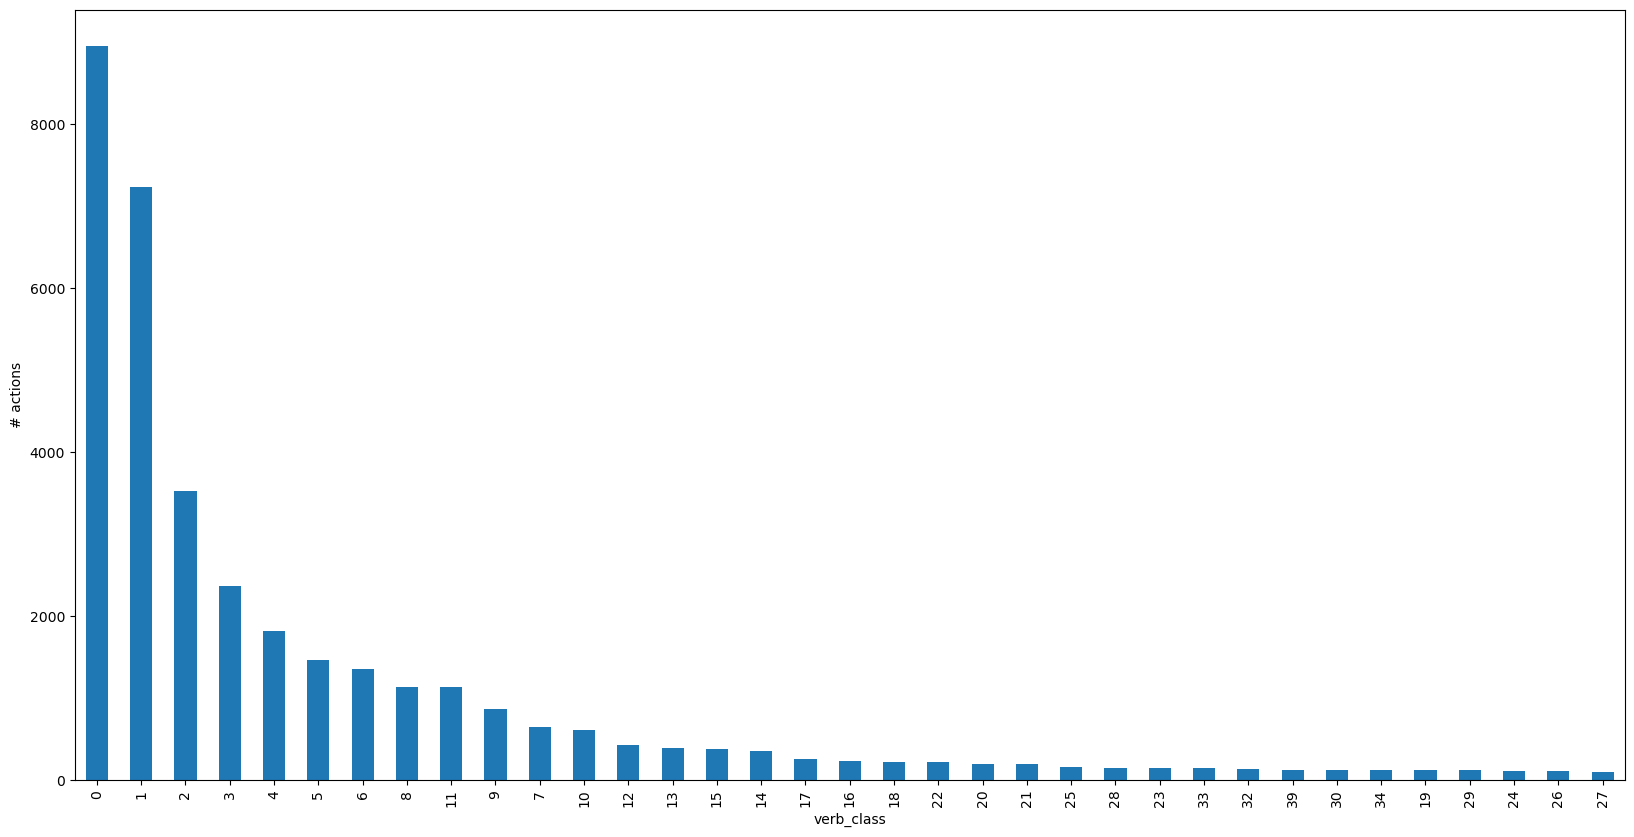

In [38]:
actions_count_per_pid.plot(kind='bar', ylabel='# actions', figsize=(20,10))

In [ ]:
total = len(annotations)
val = int(total * 0.1)
test = int(total * 0.15)
train = total - (val + test)
f'{total=}, {train=}, {val=}, {test=}'

In [ ]:
train + val + test

In [ ]:
from copy import deepcopy

train_split = {
    'sum': 0,
    'pid_arr': []
}
val_split = deepcopy(train_split)
test_split = deepcopy(train_split)

def create_split(obj: dict, split_num: int):
    for (pid, value) in actions_count_per_pid.items():
        tmp_sum = obj['sum'] + value
        if tmp_sum < split_num:
            obj['sum'] = tmp_sum
            obj['pid_arr'].append(pid)
            actions_count_per_pid.drop(pid, inplace=True)
        else:
            break
    return obj

train_split = create_split(train_split, train)
val_split = create_split(val_split, val)
test_split = create_split(test_split, test)
train_split, val_split, test_split, actions_count_per_pid

In [ ]:
actions_count_per_pid

In [ ]:
train_split['sum'] = actions_count_per_pid['P11']
train_split['pid_arr'].append('P11')

val_split['sum'] = actions_count_per_pid['P09']
val_split['pid_arr'].append('P09')

test_split['sum'] = actions_count_per_pid['P37']
test_split['pid_arr'].append('P37')

In [ ]:
train_df = annotations.loc[annotations['participant_id'].isin(train_split['pid_arr'])]
val_df = annotations.loc[annotations['participant_id'].isin(val_split['pid_arr'])]
test_df = annotations.loc[annotations['participant_id'].isin(test_split['pid_arr'])]

In [ ]:
train_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_train_clean_split.pkl'))
val_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_validation_split.pkl'))
test_df.to_pickle(os.path.join(annotations_dir, 'EPIC_100_test_split.pkl'))

## Annotations per label

actions_count_per_pid = annotations['participant_id'].value_counts()
actions_count_per_pid